# Cross validation

Finding the best hyperparameters for each model on the complete dataset.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error

from sklearn.base import BaseEstimator, RegressorMixin

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC
from sklego.meta import ZeroInflatedRegressor

import statsmodels.api as sm
from statsmodels.othermod.betareg import BetaModel

from matplotlib import pyplot as plt

from IPython.display import clear_output

import warnings

## Auxilliary functions

In [2]:
def aggregate(data_role:str, data_X:np.ndarray, data_y:np.ndarray, noSupply_value:float) -> np.ndarray:
    '''Creates a dataset from raw data according to a 5-points-wide aggregated sliding window. Assumes no header rows.
    :param: data_role: whether the array to aggregate is the predictor ("X") or target ("y")
    :param: data_X: the predictor columns of the dataset to aggregate
    :param: data_Y: the target columns of the dataset to aggregate
    :param: noSupply_value: the value to substitute in the target variable if there was no shoot supply
    :return: the aggregated data array.
    '''

    if data_role == 'X':
        processed_data = data_X.copy()

        processed_data = processed_data.astype(float)

        rows, cols = np.shape(data_X)

        for i in range(rows):
            for j in range(0, cols, 3):
                # Choosing 5 adjacent points within the limit of one forest.
                start_row = max(i - 2, int((i // 100 * 100 + 1)))
                end_row = min(i + 2, int((i // 100 + 1) * 100 - 1))

                processed_data[i, j] = np.sum(data_X[start_row:end_row+1, j].astype(float))

    elif data_role == 'y':
        processed_data = data_y.copy()

        processed_data[1:, :] = processed_data[1:, :].astype(float)

        rows, cols = np.shape(data_y)

        for i in range(rows):
            for j in range(cols):
                # Choosing 5 adjacent points within the limit of one forest.
                start_row = max(i - 2, int((i // 100 * 100) + 1))  
                end_row = min(i + 2, int((i // 100 + 1) * 100 - 1))

                aggregated_supply = np.sum(data_X[start_row:end_row+1, j * 3].astype(float))

                if aggregated_supply > 0:
                    aggregated_browsed = sum([(float(data_X[row,j*3]) / float(aggregated_supply)) * float(data_y[row,j]) \
                        for row in range(start_row, end_row+1)])

                    processed_data[i,j] = aggregated_browsed

                else:
                    processed_data[i, j] = noSupply_value

    return processed_data

def normalize_TS(X:np.ndarray) -> np.ndarray:
    '''Normalizes the TS columns of a predictor array.
    :param: X: the array which contains the columns to normalize.
    :return: the complete array in which the TS columns are now normalized.'''

    X_normalized = X.copy()

    cols_to_normalize = [i for i in range(np.shape(X)[1]) if i % 3 == 0]

    smoothing = 0.00001     # Applied so that 0 division does not cause any problems while normalizing.

    X_normalized[:, cols_to_normalize] = (X[:, cols_to_normalize] - (X[:, cols_to_normalize].min(axis=0))) \
                            / (X[:, cols_to_normalize].max(axis=0) - (X[:, cols_to_normalize].min(axis=0)) + smoothing)
    
    return X_normalized

def adjust_predictions(y_pred:np.ndarray, X:np.ndarray, noSupply_value:float) -> np.ndarray:
    '''Ensures that the specified noSupply_value is predicted whenever there is no shoot supply
    and that there are no negative predictions when there IS supply.
    :param: y_pred: the array of original predictions.
    :param: X: the array of predictors.
    :param: noSupply_value: the value to predict in case of no supply.
    :return: the adjusted array of predictions.
    '''

    y_pred_adjusted = y_pred.copy()

    for i in range(y_pred.shape[0]):
            for j in range(y_pred.shape[1]):
                if X[i, j * 3] == 0:
                    y_pred_adjusted[i, j] = noSupply_value

                elif y_pred[i, j] < 0:
                    y_pred_adjusted[i, j] = 0

    return y_pred_adjusted
    

## Loading and aggregating dataset

In [3]:
# Reading data as pandas dataframe to allow for headers
X_df = pd.read_csv('./Data/predictors_fl.csv')
y_df = pd.read_csv('./Data/freshly_browsed_dist_fl.csv')

In [4]:
# Numpy data arrays excluding headers
X = X_df.values
y = y_df.values

In [5]:
print(f'Shape of predictors: {np.shape(X)}')
print(f'Shape of target values: {np.shape(y)}')

Shape of predictors: (2100, 81)
Shape of target values: (2100, 27)


In [6]:
noSupply_value = -0.00001

In [7]:
X_agg = aggregate('X', X, y, noSupply_value)
y_agg = aggregate('y', X, y, noSupply_value)

In [8]:
X_agg = normalize_TS(X_agg)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_agg, y_agg, test_size=200, random_state=23)

## Random forest regression

In [10]:
# Perform cross-validation to find the best hyperparameters
n_estimators = [i for i in range(1, 101, 10)]
max_depth = [None]
max_depth.extend([i for i in range(1, 11, 2)])
max_samples = [None]
max_samples.extend([i/10 for i in range(2, 10, 2)])

total_combinations = len(n_estimators) * len(max_depth) * len(max_samples)
progress_counter = 0

best_score = float('inf')
best_n_estimators = None
best_max_depth = None

for est in n_estimators:
    for depth in max_depth:
        for samples in max_samples:
            rf = RandomForestRegressor(n_estimators=est, max_depth=depth, max_samples=samples, random_state=23)
            y_pred_cv = cross_val_predict(rf, X_train, y_train, cv=2)

            # Apply modification to the predicted values based on X values
            y_pred_cv = adjust_predictions(y_pred_cv, X_train, noSupply_value)

            mean_score = mean_squared_error(y_train, y_pred_cv)

            if mean_score < best_score:
                best_score = mean_score
                best_n_estimators = est
                best_max_depth = depth
                best_max_samples = samples

            progress_counter += 1
            progress_percent = progress_counter / total_combinations * 100

            clear_output(wait=True)
            print(f'Progress: {progress_percent:.1f}%')

Progress: 100.0%


In [11]:
print(f'Summary of cross validation for Random Forest:')
print(f'Number of trees: {best_n_estimators}')
print(f'Maximum tree depth: {best_max_depth}')
print(f'Number of samples used to train a single tree: {best_max_samples}')

Summary of cross validation for Random Forest:
Number of trees: 71
Maximum tree depth: None
Number of samples used to train a single tree: None


In [12]:
with open('./CV/rf.csv', 'w') as file:
    file.write(f'best_n_estimators,{best_n_estimators}\n')
    file.write(f'best_max_depth,{best_max_depth}\n')
    file.write(f'best_max_samples,{best_max_samples}')

In [13]:
# Train the random forest regressor with the best hyperparameters
rf = RandomForestRegressor(n_estimators=best_n_estimators, max_depth=best_max_depth, \
                           max_samples=best_max_samples, random_state=23)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred_test = rf.predict(X_test)

# Apply modification to the predicted values based on X values
y_pred_test = adjust_predictions(y_pred_test, X_test, noSupply_value)

# Calculate prediction errors on the test set
errors = y_pred_test - y_test

# Report the desired metrics
min_error = np.min(errors)
max_error = np.max(errors)
mean_error = np.mean(np.abs(errors))
median_error = np.median(errors)
std_error = np.std(np.abs(errors))

print(f'Summary of errors:')
print("Min Error:", min_error)
print("Max Error:", max_error)
print("Mean Error:", mean_error)
print("Median Error:", median_error)
print("Standard Deviation of Errors:", std_error)
print('')

Summary of errors:
Min Error: -0.806072292339898
Max Error: 0.29049840933714177
Mean Error: 0.0028968174312579463
Median Error: 0.0
Standard Deviation of Errors: 0.023939287319952367



In [14]:
thresholds = [0.25, 0.5, 0.75]

nr_values = y_test.shape[0] * y_test.shape[1]

threshold_tuples = [(np.sum(y_test > th) / nr_values * 100, \
                     np.count_nonzero(np.logical_and(y_test > th, y_pred_test > th)) / nr_values * 100) \
                        for th in thresholds]

negative_tuple = (np.sum(y_test < 0) / nr_values * 100, np.sum(y_pred_test < 0) / nr_values * 100)

print(f'Percentage of negative predictions (i.e., due to no supply):')
print(f'TRUE DATA - PREDICTIONS')
print(f'{negative_tuple[0]:.2f} - {negative_tuple[1]:.2f}', '\n')

for i, th in enumerate(thresholds):
    print(f'Percentage of freshly browsed values above {th}:')
    print(f'TRUE DATA - PREDICTIONS')
    print(f'{threshold_tuples[i][0]:.2f} - {threshold_tuples[i][1]:.2f}', '\n')

Percentage of negative predictions (i.e., due to no supply):
TRUE DATA - PREDICTIONS
92.33 - 92.33 

Percentage of freshly browsed values above 0.25:
TRUE DATA - PREDICTIONS
0.69 - 0.41 

Percentage of freshly browsed values above 0.5:
TRUE DATA - PREDICTIONS
0.20 - 0.09 

Percentage of freshly browsed values above 0.75:
TRUE DATA - PREDICTIONS
0.09 - 0.00 



Total number of values in target vectors: 5400


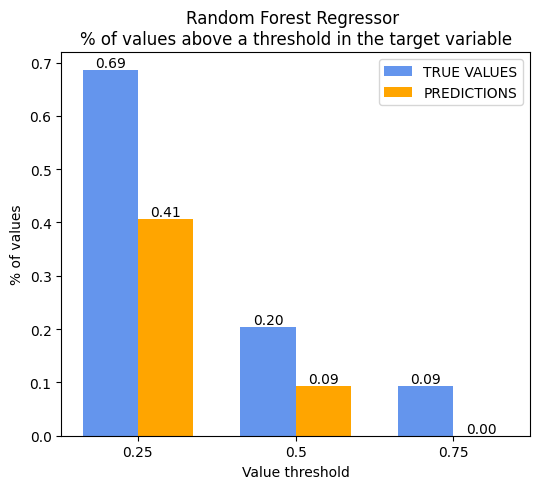

In [15]:
# Plotting difference in values above thresholds.
nr_values = y_test.shape[0] * y_test.shape[1]
print(f'Total number of values in target vectors: {nr_values}')

bar_width = 0.35

bar_positions1 = [x - bar_width / 2 for x in range(len(threshold_tuples))]
bar_positions2 = [x + bar_width / 2 for x in range(len(threshold_tuples))]

fig, ax = plt.subplots(figsize=(5.5,5))

ax.bar_label(plt.bar(bar_positions1, [t[0] for t in threshold_tuples], \
    width=bar_width, color='cornflowerblue', label='TRUE VALUES'), fmt='%.2f')
ax.bar_label(plt.bar(bar_positions2, [t[1] for t in threshold_tuples], \
    width=bar_width, color='orange', label='PREDICTIONS'), fmt='%.2f')

ax.set_xticks(range(len(threshold_tuples)), [str(th) for th in thresholds])

ax.set_xlabel('Value threshold')
ax.set_ylabel('% of values')
ax.set_title(f'Random Forest Regressor \n% of values above a threshold in the target variable')

ax.legend()

plt.tight_layout()

plt.savefig(f'./Figures/CV_RF_values_above_threshold')

plt.show()

## Gradient boosting regressor

In [16]:
# Perform cross-validation to find the best hyperparameters
learning_rates = [0.1, 0.01, 0.001]
n_estimators = [i for i in range(50, 550, 100)]
max_depth = [None]
max_depth.extend([i for i in range(1, 11, 2)])

total_combinations = len(learning_rates) * len(n_estimators) * len(max_depth)
progress_counter = 0

best_score = float('inf')
best_n_estimators = None
best_max_depth = None

for rate in learning_rates:
    for est in n_estimators:
        for depth in max_depth:
            y_pred_cv = np.zeros_like(y_train)
            gb = GradientBoostingRegressor(learning_rate=rate, n_estimators=est, max_depth=depth, random_state=42, \
                                            validation_fraction=0.1, n_iter_no_change=10)

            for i in range(np.shape(y_train)[1]):
                y_pred_cv[:,i] = cross_val_predict(gb, X_train, y_train[:,i], cv=2, n_jobs=-1)

            # Apply modification to the predicted values based on X values
            y_pred_cv = adjust_predictions(y_pred_cv, X_train, noSupply_value)

            mean_score = mean_squared_error(y_train, y_pred_cv)

            if mean_score < best_score:
                best_score = mean_score
                best_rate = rate
                best_n_estimators = est
                best_max_depth = depth

            progress_counter += 1
            progress_percent = progress_counter / total_combinations * 100

            clear_output(wait=True)
            print(f'Progress: {progress_percent:.1f}%')

print(f'Summary of cross validation for Gradient Boosting Regressor:')
print(f'Learning rate: {best_rate}')
print(f'Number of trees: {best_n_estimators}')
print(f'Maximum tree depth: {best_max_depth}')

Progress: 100.0%
Summary of cross validation for Gradient Boosting Regressor:
Learning rate: 0.1
Number of trees: 150
Maximum tree depth: 5


In [17]:
with open('./CV/gb.csv', 'w') as file:
    file.write(f'best_n_estimators,{best_n_estimators}\n')
    file.write(f'best_max_depth,{best_max_depth}\n')
    file.write(f'best_rate,{best_rate}')

In [18]:
gb = GradientBoostingRegressor(learning_rate=best_rate, n_estimators=best_n_estimators, \
    max_depth=best_max_depth, random_state=23)

y_pred_test = np.zeros_like(y_test)

for i in range(np.shape(y_test)[1]):
    gb.fit(X_train, y_train[:,i])
    y_pred_test[:,i] = gb.predict(X_test)

# Apply modification to the predicted values based on X values
y_pred_test = adjust_predictions(y_pred_test, X_test, noSupply_value)

# Calculate prediction errors on the test set
errors = y_pred_test - y_test

# Report the desired metrics
min_error = np.min(errors)
max_error = np.max(errors)
mean_error = np.mean(np.abs(errors))
median_error = np.median(errors)
std_error = np.std(np.abs(errors))

print(f'Summary of errors for Gradient Boosting Regressor:')
print("Min Error:", min_error)
print("Max Error:", max_error)
print("Mean Error:", mean_error)
print("Median Error:", median_error)
print("Standard Deviation of Errors:", std_error)
print('')

Summary of errors for Gradient Boosting Regressor:
Min Error: -0.8130936010729168
Max Error: 0.3288470340576548
Mean Error: 0.0022587639492730044
Median Error: 0.0
Standard Deviation of Errors: 0.023311184293318844



In [19]:
thresholds = [0.25, 0.5, 0.75]

nr_values = y_test.shape[0] * y_test.shape[1]

threshold_tuples = [(np.sum(y_test > th) / nr_values * 100, \
                     np.count_nonzero(np.logical_and(y_test > th, y_pred_test > th)) / nr_values * 100) \
                        for th in thresholds]

negative_tuple = (np.sum(y_test < 0) / nr_values * 100, np.sum(y_pred_test < 0) / nr_values * 100)

print(f'Percentage of negative predictions (i.e., due to no supply):')
print(f'TRUE DATA - PREDICTIONS')
print(f'{negative_tuple[0]:.2f} - {negative_tuple[1]:.2f}', '\n')

for i, th in enumerate(thresholds):
    print(f'Percentage of freshly browsed values above {th}:')
    print(f'TRUE DATA - PREDICTIONS')
    print(f'{threshold_tuples[i][0]:.2f} - {threshold_tuples[i][1]:.2f}', '\n')

Percentage of negative predictions (i.e., due to no supply):
TRUE DATA - PREDICTIONS
92.33 - 92.33 

Percentage of freshly browsed values above 0.25:
TRUE DATA - PREDICTIONS
0.69 - 0.46 

Percentage of freshly browsed values above 0.5:
TRUE DATA - PREDICTIONS
0.20 - 0.15 

Percentage of freshly browsed values above 0.75:
TRUE DATA - PREDICTIONS
0.09 - 0.04 



Total number of values in target vectors: 5400


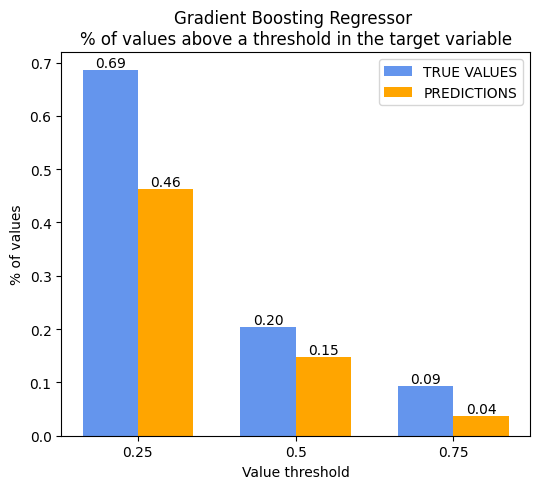

In [20]:
# Plotting difference in values above thresholds.
nr_values = y_test.shape[0] * y_test.shape[1]
print(f'Total number of values in target vectors: {nr_values}')

bar_width = 0.35

bar_positions1 = [x - bar_width / 2 for x in range(len(threshold_tuples))]
bar_positions2 = [x + bar_width / 2 for x in range(len(threshold_tuples))]

fig, ax = plt.subplots(figsize=(5.5,5))

ax.bar_label(plt.bar(bar_positions1, [t[0] for t in threshold_tuples], \
    width=bar_width, color='cornflowerblue', label='TRUE VALUES'), fmt='%.2f')
ax.bar_label(plt.bar(bar_positions2, [t[1] for t in threshold_tuples], \
    width=bar_width, color='orange', label='PREDICTIONS'), fmt='%.2f')

ax.set_xticks(range(len(threshold_tuples)), [str(th) for th in thresholds])

ax.set_xlabel('Value threshold')
ax.set_ylabel('% of values')
ax.set_title(f'Gradient Boosting Regressor \n% of values above a threshold in the target variable')

ax.legend()

plt.tight_layout()

plt.savefig(f'./Figures/CV_GB_values_above_threshold.png')

plt.show()

## Beta regression

Defining custom regressor class - an sklearn compatible beta regressor.

In [21]:
class BetaRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self):
        self.model = None

    def fit(self, X, y):
        X_statsmodels = sm.add_constant(X)
        
        self.model = BetaModel(y, X_statsmodels)

        self.results = self.model.fit()

    def predict(self, X):
        X_statsmodels = sm.add_constant(X)
        
        return self.results.predict(X_statsmodels)

In [22]:
warnings.filterwarnings('ignore')

C_s = [i for i in range(1,11)]

total_combinations = len(C_s)

progress_counter = 0

# Exhanging ones to a value very close to 1 since beta regression cannot handle exactly 1.0 values.
y_train_beta = y_train.copy()
y_train_beta[y_train_beta == 1.0] = 1.0 - (-noSupply_value)

best_score = float('inf')

for C in C_s:
    y_pred_cv = np.zeros_like(y_train_beta)

    allZero = True

    for i in range(np.shape(y_train_beta)[1]):
        br = BetaRegressor()

        zi_br = ZeroInflatedRegressor(classifier=SVC(C=C), regressor=br)    

        # Using only columns where there IS supply from the species.
        y_train_reg_rows = [r for r in range(np.shape(y_train_beta)[0]) if y_train_beta[r, i] >= 0]
        y_train_noReg_rows = [r for r in range(np.shape(y_train_beta)[0]) if r not in y_train_reg_rows]

        X_train_reg = X_train[y_train_reg_rows]
        y_train_reg = y_train_beta[y_train_reg_rows, i]

        # Ensuring that there is at least one non-zero value in the target variable.
        y_train_reg[0] = -(-noSupply_value)

        try:        # Algorithm runs into error if all predicted targets are 0 by the classifier.
            y_pred_cv[y_train_reg_rows, i] = cross_val_predict(zi_br, X_train_reg, y_train_reg, cv=2)
            allZero = False

        except:
             pass        # Nothing to do as default prediction is 0.

        # Setting prediction for rows with no supply.
        y_pred_cv[y_train_noReg_rows, i] = noSupply_value

    # Importantly, the error is calculated with respect to the unmodified data.
    mean_score = mean_squared_error(y_train, y_pred_cv)

    if mean_score < best_score and allZero != True:     # Ensuring that the selected model does not classify all instances as 0 target.
        best_score = mean_score
        best_C = C

    progress_counter += 1
    progress_percent = progress_counter / total_combinations * 100

    clear_output(wait=True)
    print(f'Progress: {progress_percent:.1f}%')

print(f'Summary of cross validation for Zero-Inflated Beta Regressor:')
print(f'Classifier C value: {best_C}')

Progress: 100.0%
Summary of cross validation for Zero-Inflated Beta Regressor:
Classifier C value: 1


In [23]:
with open('./CV/br.csv', 'w') as file:
    file.write(f'best_C,{best_C}')

In [25]:
# Exchanging ones to a value very close to 1 since beta regression cannot handle exactly 1.0 values.
y_train_beta = y_train.copy()
y_train_beta[y_train_beta == 1.0] = 1.0 - (-noSupply_value)

y_test_beta = y_test.copy()
y_test_beta[y_test_beta == 1.0] = 1.0 - (-noSupply_value)

y_pred_test = np.zeros_like(y_test)

zi_br = ZeroInflatedRegressor(classifier=SVC(C=best_C), regressor=BetaRegressor())

for i in range(np.shape(y_test_beta)[1]):
        # Using only rows where there WAS supply from the species.
        reg_rows = [r for r in range(np.shape(y_test_beta)[0]) if y_test_beta[r, i] >= 0]
        noReg_rows = [r for r in range(np.shape(y_test_beta)[0]) if r not in reg_rows]

        X_train_reg = X_train[reg_rows]
        y_train_reg = y_train_beta[reg_rows, i]

        if len(y_train_reg) > 0:
                # Ensuring that there is at least one non-zero value in the target variable.
                y_train_reg[0] = -(-noSupply_value)
                
                X_test_reg = X_test[reg_rows]

                try:    # Runs into error if all target values are 0, so in that case, all predictions are set to 0.
                        zi_br.fit(X_train_reg, y_train_reg)
                        y_pred_test[reg_rows,i] = zi_br.predict(X_test_reg)

                except:
                        pass    # Nothing to do as default prediction is 0.

        # Setting prediction for rows with no supply.
        y_pred_test[noReg_rows, i] = noSupply_value

# Calculate prediction errors on the test set
errors = y_pred_test - y_test

# Report the desired metrics
min_error = np.min(errors)
max_error = np.max(errors)
mean_error = np.mean(np.abs(errors))
median_error = np.median(errors)
std_error = np.std(np.abs(errors))

print(f'Summary of errors for Zero-Inflated Beta Regressor:')
print("Min Error:", min_error)
print("Max Error:", max_error)
print("Mean Error:", mean_error)
print("Median Error:", median_error)
print("Standard Deviation of Errors:", std_error)
print('')

warnings.filterwarnings('default')

Summary of errors for Zero-Inflated Beta Regressor:
Min Error: -1.0
Max Error: 0.0
Mean Error: 0.004757787982743302
Median Error: 0.0
Standard Deviation of Errors: 0.045401708077285864



In [26]:
thresholds = [0.25, 0.5, 0.75]

nr_values = y_test.shape[0] * y_test.shape[1]

threshold_tuples = [(np.sum(y_test > th) / nr_values * 100, \
                     np.count_nonzero(np.logical_and(y_test > th, y_pred_test > th)) / nr_values * 100) \
                        for th in thresholds]

negative_tuple = (np.sum(y_test < 0) / nr_values * 100, np.sum(y_pred_test < 0) / nr_values * 100)

print(f'Percentage of negative predictions (i.e., due to no supply):')
print(f'TRUE DATA - PREDICTIONS')
print(f'{negative_tuple[0]:.2f} - {negative_tuple[1]:.2f}', '\n')

for i, th in enumerate(thresholds):
    print(f'Percentage of freshly browsed values above {th}:')
    print(f'TRUE DATA - PREDICTIONS')
    print(f'{threshold_tuples[i][0]:.2f} - {threshold_tuples[i][1]:.2f}', '\n')

Percentage of negative predictions (i.e., due to no supply):
TRUE DATA - PREDICTIONS
92.33 - 92.33 

Percentage of freshly browsed values above 0.25:
TRUE DATA - PREDICTIONS
0.69 - 0.00 

Percentage of freshly browsed values above 0.5:
TRUE DATA - PREDICTIONS
0.20 - 0.00 

Percentage of freshly browsed values above 0.75:
TRUE DATA - PREDICTIONS
0.09 - 0.00 



Total number of values in target vectors: 5400


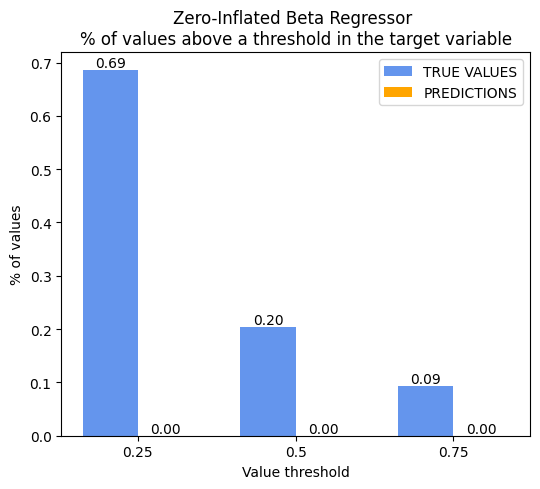

In [27]:
# Plotting difference in values above thresholds.
nr_values = y_test.shape[0] * y_test.shape[1]
print(f'Total number of values in target vectors: {nr_values}')

bar_width = 0.35

bar_positions1 = [x - bar_width / 2 for x in range(len(threshold_tuples))]
bar_positions2 = [x + bar_width / 2 for x in range(len(threshold_tuples))]

fig, ax = plt.subplots(figsize=(5.5,5))

ax.bar_label(plt.bar(bar_positions1, [t[0] for t in threshold_tuples], \
    width=bar_width, color='cornflowerblue', label='TRUE VALUES'), fmt='%.2f')
ax.bar_label(plt.bar(bar_positions2, [t[1] for t in threshold_tuples], \
    width=bar_width, color='orange', label='PREDICTIONS'), fmt='%.2f')

ax.set_xticks(range(len(threshold_tuples)), [str(th) for th in thresholds])

ax.set_xlabel('Value threshold')
ax.set_ylabel('% of values')
ax.set_title(f'Zero-Inflated Beta Regressor \n% of values above a threshold in the target variable')

ax.legend()

plt.tight_layout()

plt.savefig(f'./Figures/CV_BR_values_above_threshold.png')

plt.show()